# plots for GEV attribution paper

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy as cart
import cartopy.crs as ccrs
from matplotlib import font_manager
import pyarrow.parquet as pq
import seaborn as sns
from scipy import stats
from scipy.stats import genextreme as gev
import scipy

data locations

In [2]:
loc_params = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/Fitted_Parameters/"
loc_emissions = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/Emissions/"
loc_carbonmajors = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/CarbonMajors/"
loc_figs = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Figures/"
loc_txx = "/N/project/climatesociety/datasets/ERA5/annual/"
loc_rx1day = "/N/project/climatesociety/datasets/CPC/annual/"
loc_out = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/GEV_Predictions/"
loc_lsm = "/N/project/climatesociety/datasets/LandSea/2p5degree/"
loc_ceds = "/N/u/ccallah/Quartz/Projects/Extremes_Emissions/Data/CEDS/CEDS_v_2024_04_01_aggregate/"
loc_mmlea_rx1day = "/N/project/climatesociety/datasets/MMLEA/annual/rx1day/"
loc_mmlea_txx = "/N/project/climatesociety/datasets/MMLEA/annual/txx/"

Custom cmap for precip

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('BrBG', 256)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 0.5, 128)),
                       bottom(np.linspace(0, 1, 128))))
precip_cmap = ListedColormap(newcolors, name='BrownBlue')

/tmp/ipykernel_261559/2496032520.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('BrBG', 256)
/tmp/ipykernel_261559/2496032520.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('Blues', 128)


Land sea mask

In [4]:
lsm_in = xr.open_dataarray(loc_lsm+"IMERG_land1_sea0_mask_2p5degree.nc")
lsm = lsm_in.where(lsm_in==1,np.nan)

Weights

In [5]:
# spatial weights
wgt = xr.DataArray(np.zeros((len(lsm.lat),len(lsm.lon))),
                coords=[lsm.lat,lsm.lon],dims=["lat","lon"])
for ll in np.arange(0,len(lsm.lon),1):
    wgt[:,ll] = np.cos(np.radians(lsm.lat))

Emissions

In [6]:
emissions = pd.read_csv(loc_emissions+"global_emissions_historical_ssp_interpolated_1750-2100.csv",index_col=0)
cemissions = emissions.loc[:,["year","scenario","cumulative_emissions_gtco2"]]
cemissions = cemissions.set_index(["year","scenario"])
emissions_xr = cemissions.to_xarray().load()

In [7]:
## 1750-2022
ceds_in = pd.read_csv(loc_ceds+"CO2_CEDS_emissions_by_country_v2024_04_01.csv")
carbonmajors_in = pd.read_csv(loc_carbonmajors+"emissions_high_granularity.csv")

In [8]:
ceds = pd.melt(ceds_in,id_vars=["em","country","units"],var_name="year",value_name="emissions_ktco2")
ceds["year"] = [int(x[1:5]) for x in ceds.year.values]
ceds["emissions_gtco2"] = (ceds.emissions_ktco2*1e3)/1e9

In [9]:
carbonmajors = carbonmajors_in.loc[carbonmajors_in.parent_type!="Nation State",:].groupby(["year","parent_entity","parent_type"]).sum().reset_index()
carbonmajors = carbonmajors.drop(columns=["lei","reporting_entity","commodity","production_value","production_unit","source"])
carbonmajors["total_emissions_mtco2"] = carbonmajors.product_emissions_MtCO2 + carbonmajors.flaring_emissions_MtCO2 + \
                    carbonmajors.venting_emissions_MtCO2 + carbonmajors.own_fuel_use_emissions_MtCO2
carbonmajors["total_emissions_gtco2"] = carbonmajors.total_emissions_mtco2/1000

Parameters

In [10]:
scen = "ssp585"
params_df_txx = pq.read_table(loc_params+"mmlea_txx_gev_"+scen+"_cumulativeemissions_bymodel_params_1850-2100.parquet").to_pandas().drop(columns="ks_pvalue")
params_df_txx = params_df_txx.set_index(["lat","lon","model"])
params_txx = params_df_txx.to_xarray()
models = params_txx.model.values
modelnames = xr.DataArray([x.split("_")[0] for x in models],dims=["model"],coords=[models])
modelwgts = xr.DataArray(np.array([1/np.sum(modelnames==x) for x in modelnames]),dims=["model"],coords=[models])
params_txx.coords["modelwgt"] = modelwgts

params_df_rx1day = pq.read_table(loc_params+"mmlea_rx1day_gev_"+scen+"_cumulativeemissions_bymodel_params_1850-2100.parquet").to_pandas().drop(columns="ks_pvalue")
params_df_rx1day = params_df_rx1day.set_index(["lat","lon","model"])
params_rx1day = params_df_rx1day.to_xarray()
params_rx1day.coords["modelwgt"] = modelwgts

mask for where obs and modeled parameters are similar

In [28]:
params_mask = xr.open_dataset(loc_params+scen+"_obs_mmlea_parameter_masks.nc")
txx_mask = params_mask.data_vars["txx_mask"].where(params_mask.data_vars["txx_mask"]==1,np.nan)
rx1day_mask = params_mask.data_vars["rx1day_mask"].where(params_mask.data_vars["rx1day_mask"]==1,np.nan)

Put together df for writing out

In [29]:
txx_mu0 = (params_txx.data_vars["mu0"]*txx_mask).weighted(params_txx.modelwgt).quantile(q=0.5,dim="model")
txx_mu1 = (params_txx.data_vars["mu1"]*txx_mask).weighted(params_txx.modelwgt).quantile(q=0.5,dim="model")
txx_sigma0 = (params_txx.data_vars["sigma0"]*txx_mask).weighted(params_txx.modelwgt).quantile(q=0.5,dim="model")
txx_sigma1 = (params_txx.data_vars["sigma1"]*txx_mask).weighted(params_txx.modelwgt).quantile(q=0.5,dim="model")
txx_shape = (params_txx.data_vars["shape"]*txx_mask).weighted(params_txx.modelwgt).quantile(q=0.5,dim="model")
txx_mu0.name = "mu0"
txx_mu1.name = "mu1"
txx_sigma0.name = "sigma0"
txx_sigma1.name = "sigma1"
txx_shape.name = "shape"
txx_df_out = pd.merge(txx_mu0.to_dataframe().reset_index().drop(columns="quantile"),txx_mu1.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])
txx_df_out = pd.merge(txx_df_out,txx_sigma0.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])
txx_df_out = pd.merge(txx_df_out,txx_sigma1.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])
txx_df_out = pd.merge(txx_df_out,txx_shape.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])

In [30]:
rx1day_mu0 = (params_rx1day.data_vars["mu0"]*rx1day_mask).weighted(params_rx1day.modelwgt).quantile(q=0.5,dim="model")
rx1day_mu1 = (params_rx1day.data_vars["mu1"]*rx1day_mask).weighted(params_rx1day.modelwgt).quantile(q=0.5,dim="model")
rx1day_sigma0 = (params_rx1day.data_vars["sigma0"]*rx1day_mask).weighted(params_rx1day.modelwgt).quantile(q=0.5,dim="model")
rx1day_sigma1 = (params_rx1day.data_vars["sigma1"]*rx1day_mask).weighted(params_rx1day.modelwgt).quantile(q=0.5,dim="model")
rx1day_shape = (params_rx1day.data_vars["shape"]*rx1day_mask).weighted(params_rx1day.modelwgt).quantile(q=0.5,dim="model")
rx1day_mu0.name = "mu0"
rx1day_mu1.name = "mu1"
rx1day_sigma0.name = "sigma0"
rx1day_sigma1.name = "sigma1"
rx1day_shape.name = "shape"
rx1day_df_out = pd.merge(rx1day_mu0.to_dataframe().reset_index().drop(columns="quantile"),rx1day_mu1.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])
rx1day_df_out = pd.merge(rx1day_df_out,rx1day_sigma0.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])
rx1day_df_out = pd.merge(rx1day_df_out,rx1day_sigma1.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])
rx1day_df_out = pd.merge(rx1day_df_out,rx1day_shape.to_dataframe().reset_index().drop(columns="quantile"),
                      how="left",on=["lat","lon"])

In [32]:
txx_df_out.dropna().to_csv(loc_params+"txx_parameters.csv")
rx1day_df_out.dropna().to_csv(loc_params+"rx1day_parameters.csv")

Four maps for the parameters

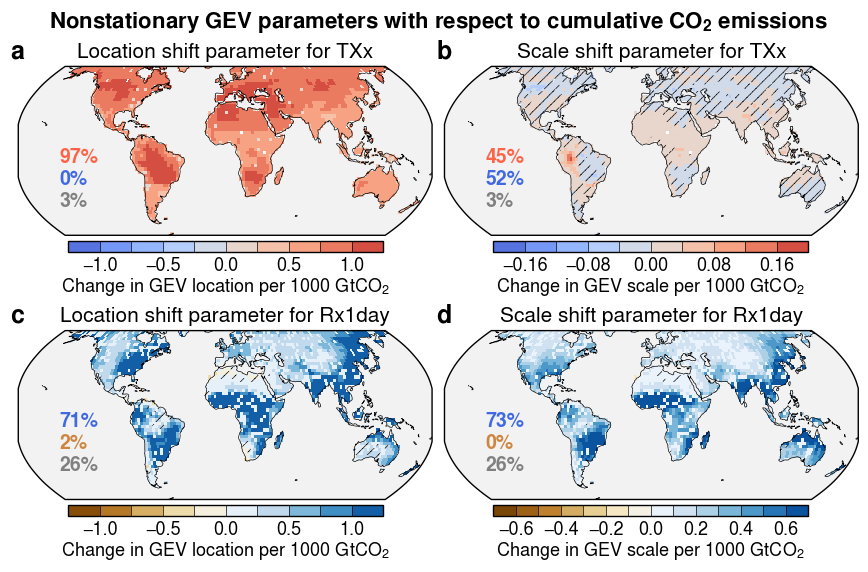

In [12]:
fig = plt.figure(figsize=(10,6))
tfs = 15
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.94,top=0.92,bottom=0.09,wspace=0.03,hspace=0.13)

extremes = ["txx","rx1day"]
ext_names = ["TXx","Rx1day"]
nms = ["Location","Scale"]
lefts = [0.15,0.575]
bottoms = [0.557,0.117]

lbx = -0.02
lby = 1.05

for ee in np.arange(0,len(extremes),1):
    if ee==0:
        ds = params_txx
        mask = params_mask.data_vars["txx_mask"]
        lbs = ["a","b"]
    elif ee==1:
        ds = params_rx1day
        mask = params_mask.data_vars["rx1day_mask"]
        lbs = ["c","d"]
        
    for j in np.arange(0,len(nms),1):
        if j == 0:
            dat_all = (ds.data_vars["mu1"]*mask)*1000
            cmin = -1.25
            cmax = 1.25
            nrange = 11
        elif (j == 1)&(ee==0):
            dat_all = (ds.data_vars["sigma1"]*mask)*1000
            cmin = -0.2
            cmax = 0.2
            nrange = 11
        elif (j==1)&(ee==1):
            dat_all = (ds.data_vars["sigma1"]*mask)*1000
            cmin = -0.7
            cmax = 0.7
            nrange = 15

        # plot median and uncertainty
        #dat = dat_all.median(dim="model")
        dat = dat_all.weighted(dat_all.modelwgt).quantile(q=0.5,dim="model")
        dat_uncert_inc = (dat_all>0).mean(dim="model")
        dat_uncert_dec = (dat_all<0).mean(dim="model")

        # draw map
        ax = plt.subplot(gs1[ee,j],projection=ccrs.Robinson())
        ax.set_extent([-180,180,-65,65],crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_zorder(11)
        ax.coastlines(linewidth=0.5,zorder=9)
        ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.95,0.95,0.95])
        
        plt.title(nms[j]+" shift parameter for "+ext_names[ee],fontsize=tfs)
        plt.text(lbx,lby,lbs[j],fontsize=18,transform=ax.transAxes,fontweight="bold")
        
        # cmap
        
        bounds = np.linspace(cmin,cmax,nrange)
        if ee==0:
            cols = plt.get_cmap('coolwarm')(np.linspace(0,1,len(bounds)+1))
        else:
            cols = precip_cmap(np.linspace(0,1,len(bounds)+1))
        cmap = colors.ListedColormap(cols[1:-1])
        cmap.set_over(cols[-1])
        cmap.set_under(cols[0])
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
        
        # plot
        data_plot = dat.clip(min=cmin+(cmin*0.01),max=cmax-(cmax*0.01))
        ax.pcolormesh(data_plot.lon,data_plot.lat,data_plot,
                      zorder=7,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
        data_plot_u1 = data_plot.where((dat>0)&(dat_uncert_inc<0.66),np.nan)
        data_plot_u2 = data_plot.where((dat<0)&(dat_uncert_dec<0.66),np.nan)
        ax.pcolor(data_plot_u1.lon,data_plot_u1.lat,data_plot_u1,hatch="///",
                      zorder=8,transform=ccrs.PlateCarree(),cmap=ListedColormap(['none']))
        ax.pcolor(data_plot_u2.lon,data_plot_u2.lat,data_plot_u2,hatch="///",
                      zorder=8,transform=ccrs.PlateCarree(),cmap=ListedColormap(['none']))

        # print out stat
        dat_flat = dat.values.flatten()
        dat_notna = dat_flat[~np.isnan(dat_flat)]
        #print(np.mean(dat_notna>0))

        if ee==0:
            textcol1 = "tomato"
            textcol2 = "royalblue"
        else:
            textcol1 = "royalblue"
            textcol2 = "peru"
            
        plt.text(0.1,0.43,str(int(np.around(np.mean(dat_notna>0)*100)))+"%",fontsize=14,
                 color=textcol1,fontweight="bold",transform=ax.transAxes)
        plt.text(0.1,0.3,str(int(np.around(np.mean(dat_notna<0)*100)))+"%",fontsize=14,
                 color=textcol2,fontweight="bold",transform=ax.transAxes)
        plt.text(0.1,0.17,str(int(np.around(np.mean(dat_notna==0)*100)))+"%",fontsize=14,
                 color="gray",fontweight="bold",transform=ax.transAxes)


        # cbar
        cbar_ax = fig.add_axes([lefts[j],bottoms[ee],0.315,0.018])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                              drawedges=True,extend="neither")
        cb.ax.tick_params(direction="in",width=0,which="major",labelsize=tfs-2)
        cb.ax.tick_params(direction="in",width=0,which="minor")
        cb.ax.set_xticklabels
        cb.set_label(r"Change in GEV "+nms[j].lower()+r" per 1000 GtCO$_2$",labelpad=1,fontsize=tfs-2)
        
plt.figtext(0.52,0.93,r"Nonstationary GEV parameters with respect to cumulative CO$_2$ emissions",weight='bold',fontsize=tfs+1,
            ha="center")

plt.savefig(loc_figs+"Fig2_Oct2025.pdf")
plt.show()

Read obs

In [13]:
obs_txx_ds = xr.open_mfdataset([loc_txx+x for x in sorted(os.listdir(loc_txx))],combine="nested",concat_dim="time")
obs_txx_ds.coords["time"] = np.arange(1979,2024+1,1)
obs_txx = obs_txx_ds.data_vars["txx"].load()

In [14]:
obs_rx1day_ds = xr.open_mfdataset([loc_rx1day+x for x in sorted(os.listdir(loc_rx1day))],combine="nested",concat_dim="time")
obs_rx1day_ds.coords["time"] = np.arange(1979,2024+1,1)
obs_rx1day = obs_rx1day_ds.data_vars["rx1day"].load()

Predictions at various cumulative emissions levels

In [15]:
# calculate probability from magnitude
def calc_prob(value,mu0,mu1,sigma0,sigma1,shape,cov_val):
    p = 1 - gev.cdf(x=value,c=shape,loc=mu0+(mu1*cov_val),scale=sigma0+(sigma1*cov_val))
    return(p)
# calculate magnitude from return period (probability)
def calc_mag_of_rp(rp,mu0,mu1,sigma0,sigma1,shape,cov_val):
    # rp should be number of years, like 1000 for 1000-yr event
    prob = 1 - (1/rp) # should be 0.999 for 1000-yr event
    mag = gev.ppf(q=prob,c=shape,loc=mu0+(mu1*cov_val),scale=sigma0+(sigma1*cov_val))
    return(mag)

Find obs max and year of obs max

In [16]:
yr_begin_max = 2020
obs_txx_max = obs_txx.loc[yr_begin_max:,:,:].max(dim="time")*lsm
obs_txx_maxyr = xr.DataArray((yr_begin_max + np.argmax(obs_txx.loc[yr_begin_max:,:,:].values,axis=0)),
                                coords=[obs_txx_max.lat,obs_txx_max.lon],dims=["lat","lon"])
obs_rx1day_max = obs_rx1day.loc[yr_begin_max:,:,:].max(dim="time")*lsm

In [17]:
#f_emissions = emissions.loc[emissions.year==yr_begin_max-1,"cumulative_emissions_gtco2"].values[0]
#cf_emissions = 0

Calculate change in probability due to various actors

In [18]:
models = params_txx.model.values
modelnames = xr.DataArray([x.split("_")[0] for x in models],dims=["model"],coords=[models])
modelwgts = xr.DataArray(np.array([1/np.sum(modelnames==x) for x in modelnames]),dims=["model"],coords=[models])

In [19]:
actors = np.array(["all","usa","chn","chevron","exxon","20gt"])
emissions_subtract = np.array([0,ceds.loc[(ceds.country=="usa")&(ceds.year<yr_begin_max),:].emissions_gtco2.sum(),
                               ceds.loc[(ceds.country=="chn")&(ceds.year<yr_begin_max),:].emissions_gtco2.sum(),
                              carbonmajors.loc[(carbonmajors.parent_entity=="Chevron")&(carbonmajors.year<yr_begin_max),:].total_emissions_gtco2.sum(),
                              carbonmajors.loc[(carbonmajors.parent_entity=="ExxonMobil")&(carbonmajors.year<yr_begin_max),:].total_emissions_gtco2.sum(),
                              20])
prob_ratios = xr.DataArray(np.full((2,len(actors),len(obs_txx_max.lat),len(obs_txx_max.lon),len(models)),np.nan),
                           coords=[["txx","rx1day"],actors,obs_txx_max.lat,obs_txx_max.lon,models],
                           dims=["extreme","actor","lat","lon","model"])
prob_ratios.coords["modelname"] = modelnames
prob_ratios.coords["modelwgt"] = modelwgts

for e in ["txx","rx1day"]:
    print(e)
    if e=="txx":
        obs = obs_txx_max
        params = params_txx
    else:
        obs = obs_rx1day_max
        params = params_rx1day
    for aa in np.arange(0,len(actors),1):
        a = actors[aa]
        print(a)
        f_emissions = emissions.loc[emissions.year==yr_begin_max-1,"cumulative_emissions_gtco2"].values[0]
        
        if a=="all":
            cf_emissions = 0
        else:
            cf_emissions = f_emissions - emissions_subtract[aa]
    
        prob1 = xr.apply_ufunc(calc_prob,obs,params.data_vars["mu0"],
                           params.data_vars["mu1"],params.data_vars["sigma0"],
                           params.data_vars["sigma1"],params.data_vars["shape"]*-1,
                           f_emissions)
        prob0 = xr.apply_ufunc(calc_prob,obs,params.data_vars["mu0"],
                               params.data_vars["mu1"],params.data_vars["sigma0"],
                               params.data_vars["sigma1"],params.data_vars["shape"]*-1,
                               cf_emissions)
        
        #p_ratio = prob1.median(dim="model")/prob0.median(dim="model")
        prob_ratios.loc[e,a,:,:,:] = prob1.values/prob0.values
#prob_ratios_cap = prob_ratios.where(prob_ratios<100,100).where(~np.isnan(prob_ratios),np.nan)

txx
all
usa


/tmp/ipykernel_163525/481010235.py:41: RuntimeWarning: divide by zero encountered in divide
  prob_ratios.loc[e,a,:,:,:] = prob1.values/prob0.values
/tmp/ipykernel_163525/481010235.py:41: RuntimeWarning: invalid value encountered in divide
  prob_ratios.loc[e,a,:,:,:] = prob1.values/prob0.values


chn
chevron
exxon
20gt
rx1day
all
usa
chn
chevron
exxon
20gt


/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarray/core/weighted.py:401: RuntimeWarning: invalid value encountered in multiply
  return (data * w).sum(axis=1)
/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarray/core/weighted.py:401: RuntimeWarning: invalid value encountered in multiply
  return (data * w).sum(axis=1)
/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarray/core/weighted.py:401: RuntimeWarning: invalid value encountered in multiply
  return (data * w).sum(axis=1)
/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarray/core/weighted.py:401: RuntimeWarning: invalid value encountered in multiply
  return (data * w).sum(axis=1)
/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarray/core/weighted.py:401: RuntimeWarning: invalid value encountered in multiply
  return (data * w).sum(axis=1)
/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarra

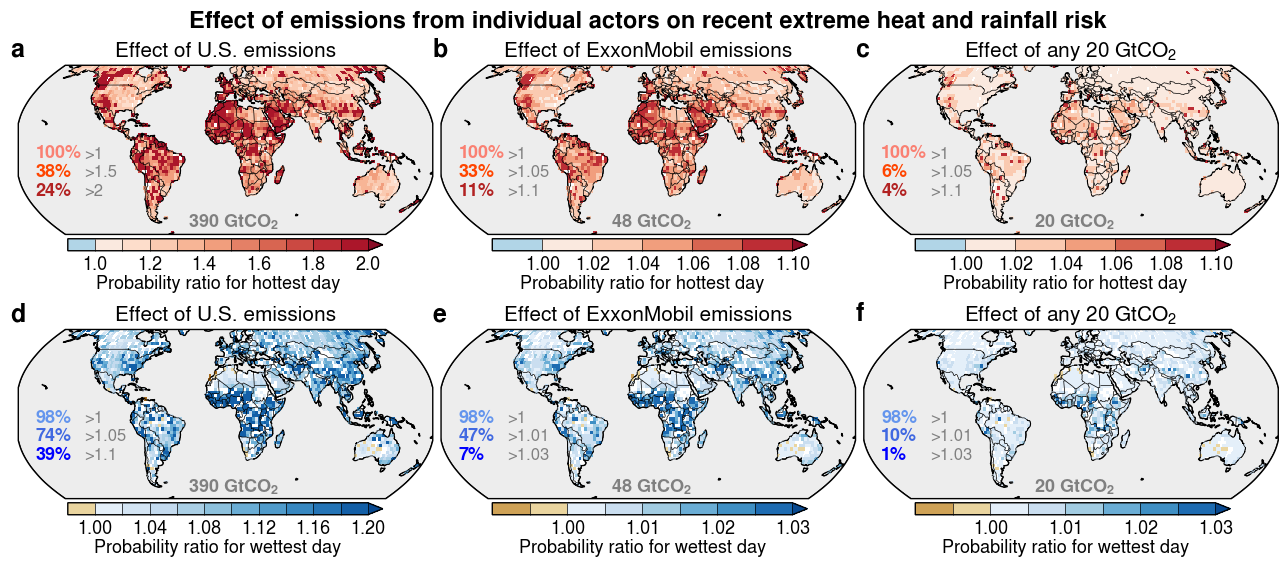

In [48]:
fig = plt.figure(figsize=(15,6))
tfs = 15

actors_plot = ["usa","exxon","20gt"]
names = ["U.S. emissions","ExxonMobil emissions","any 20 GtCO$_2$"]
lefts = [0.133,0.416,0.698]
bottoms = [0.557,0.117]
lbx = -0.02
lby = 1.05

gs1 = gridspec.GridSpec(2,len(actors_plot))
gs1.update(left=0.1,right=0.94,top=0.92,bottom=0.09,wspace=0.02,hspace=0.13)

for ee in np.arange(0,2,1):
    if ee==0:
        e = "txx"
        ename = "hottest day"
        lbs = ["a","b","c"]
        mask = params_mask.data_vars["txx_mask"]
    else:
        e = "rx1day"
        ename = "wettest day"
        lbs = ["d","e","f"]
        mask = params_mask.data_vars["rx1day_mask"]
        
    for aa in np.arange(0,len(actors_plot),1):
        a = actors_plot[aa]
        
        ax = plt.subplot(gs1[ee,aa],projection=ccrs.Robinson())
        ax.set_extent([-180,180,-65,65],crs=ccrs.PlateCarree())
        for spine in ax.spines.values():
            spine.set_zorder(11)
        ax.coastlines(linewidth=0.5,zorder=8)
        ax.add_feature(cart.feature.OCEAN, edgecolor="black",facecolor=[0.93,0.93,0.93])
        ax.add_feature(cart.feature.BORDERS, edgecolor="black",linewidth=0.5,zorder=10)
        
        plt.title("Effect of "+names[aa],fontsize=tfs)

        if e=="txx":
            if a in ["usa","chn"]:
                cmin = 0.9
                cmax = 2
                levels = np.arange(cmin,cmax+0.1,0.1)
                dec_levels = levels[:2]
                inc_levels = levels[2:]
                ticks = [1,1.2,1.4,1.6,1.8,2]
            else:
                cmin = 0.98
                cmax = 1.1
                levels = np.arange(cmin,cmax+0.02,0.02)
                dec_levels = levels[:2]
                inc_levels = levels[2:]
                ticks = [1,1.02,1.04,1.06,1.08,1.1]
        elif e=="rx1day":
            if a in ["usa","chn"]:
                cmin = 0.98
                cmax = 1.2
                levels = np.arange(cmin,cmax+0.02,0.02)
                dec_levels = levels[:2]
                inc_levels = levels[1:]
                #ticks = [1,1.02,1.04,1.06,1.08,1.1]
                ticks = [1,1.04,1.08,1.12,1.16,1.2]
            else:
                cmin = 0.99
                cmax = 1.03
                levels = np.arange(cmin,cmax+0.005,0.005)
                dec_levels = levels[:3]
                inc_levels = levels[2:]
                ticks = [1,1.01,1.02,1.03]

        if ee==0:
            dec_cols = plt.get_cmap('RdBu_r')(np.linspace(0.15,0.35,len(dec_levels)))
            inc_cols = plt.get_cmap("RdBu_r")(np.linspace(0.55,0.95,len(inc_levels)))
        else:
            dec_cols = precip_cmap(np.linspace(0.15,0.35,len(dec_levels)))
            inc_cols = precip_cmap(np.linspace(0.55,0.95,len(inc_levels)))
        cols = np.concatenate([dec_cols,inc_cols])
        cmap = mpl.colors.ListedColormap(cols[1:-1])
        cmap.set_under(cols[0])
        cmap.set_over(cols[-1])
        norm = plt.Normalize(vmin=cmin,vmax=cmax)
        cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
        
        # plot
        data_ae = prob_ratios.loc[e,a,:,:,:]
        data_plot = data_ae.weighted(data_ae.modelwgt).quantile(q=0.5,dim="model") #.mean(dim="model")
        data_plot_final = (data_plot.where(data_plot<cmax,cmax))*(mask.where(mask==1,np.nan))
        
        ax.pcolormesh(data_plot_final.lon,data_plot_final.lat,data_plot_final.values,
                      zorder=7,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
        ## text for numbers above 1, 10, etc.
        pr_flat = data_plot_final.values.flatten()
        pr_notna = pr_flat[~np.isnan(pr_flat)]
        if e=="txx":
            prt_cols = ["salmon","orangered","firebrick"]
            if a=="all":
                pr_thresholds = [1,10,100]
            elif a in ["usa","chn"]:
                pr_thresholds = [1,1.5,2]
            else:
                pr_thresholds = [1,1.05,1.1]
        elif e=="rx1day":
            prt_cols = ["cornflowerblue","royalblue","blue"]
            if a=="all":
                pr_thresholds = [1,10,100]
            elif a in ["usa","chn"]:
                pr_thresholds = [1,1.05,1.1]
            else:
                pr_thresholds = [1,1.01,1.03]
            
        for tt in np.arange(0,len(pr_thresholds),1):
            prt = pr_thresholds[tt]
            if prt==cmax:
                val = np.mean(pr_notna>=prt)
            else:
                val = np.mean(pr_notna>prt)
            plt.text(0.042,0.45-(tt*0.11),str(int(np.around(val*100)))+"%",fontsize=13,
                             color=prt_cols[tt],fontweight="bold",transform=ax.transAxes)
            plt.text(0.16,0.45-(tt*0.11),">"+str(prt),fontsize=12,color=[0.5,0.5,0.5],transform=ax.transAxes)
    
        emis_a = emissions_subtract[list(actors).index(a)]
        plt.text(0.41,0.04,str(int(np.around(emis_a)))+r" GtCO$_2$",fontsize=13,
                     color=[0.5,0.5,0.5],fontweight="bold",transform=ax.transAxes)

        plt.text(lbx,lby,lbs[aa],fontsize=18,transform=ax.transAxes,fontweight="bold")
        
        cbar_ax = fig.add_axes([lefts[aa],bottoms[ee],0.21,0.02])
        cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                            drawedges=True,extend="max",ticks=ticks)
        cb.ax.tick_params(direction="in",width=0,which="major",labelsize=tfs-2)
        cb.ax.tick_params(direction="out",width=0,which="minor")
        #cb.ax.set_xticklabels(lbs)
        cb.set_label(r"Probability ratio for "+ename,labelpad=1,fontsize=tfs-2)
    
plt.figtext(0.52,0.93,r"Effect of emissions from individual actors on recent extreme heat and rainfall risk",weight='bold',fontsize=tfs+2,
            ha="center")

plt.savefig(loc_figs+"Fig3_Oct2025_v2.pdf")
plt.show()

In [49]:
rps = np.array([100,1000])
emis = np.arange(0,400+1,1)
event_prob_changes = xr.DataArray(np.full((2,len(rps),len(emis),len(obs_txx_max.lat),len(obs_txx_max.lon),len(models)),np.nan),
                           coords=[["txx","rx1day"],rps,emis,obs_txx_max.lat,obs_txx_max.lon,models],
                           dims=["extreme","rp","emission","lat","lon","model"])
for e in ["txx","rx1day"]:
    print(e)
    if e=="txx":
        params = params_txx
    else:
        params = params_rx1day
    for r_p in np.arange(0,len(rps),1):
        rp = rps[r_p]
        print(rp)

        for em in emis:
            f_emissions = emissions.loc[emissions.year==2023,"cumulative_emissions_gtco2"].values[0]
            cf_emissions = f_emissions - em

            mag1 = xr.apply_ufunc(calc_mag_of_rp,rp,params.data_vars["mu0"],
                               params.data_vars["mu1"],params.data_vars["sigma0"],
                               params.data_vars["sigma1"],params.data_vars["shape"]*-1,
                               f_emissions)

            prob0 = xr.apply_ufunc(calc_prob,mag1,params.data_vars["mu0"],
                               params.data_vars["mu1"],params.data_vars["sigma0"],
                               params.data_vars["sigma1"],params.data_vars["shape"]*-1,
                               cf_emissions)

            #prob0 = 1/rp
            prob1 = 1/rp
            #prob_change = prob1/prob0
            event_prob_changes.loc[e,rp,em,:,:,:] = prob1/prob0

txx
100


/N/u/ccallah/Quartz/.conda/envs/ccallahan/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


1000
rx1day
100
1000


In [50]:
carbonmajors_ioc = carbonmajors.loc[carbonmajors.parent_type=="Investor-owned Company",:]
#carbonmajors_ioc.groupby(["parent_entity","parent_type"]).sum().reset_index().sort_values(by="total_emissions_gtco2",ascending=False).iloc[0:12,:]
cms = ["Chevron","ExxonMobil","Shell","BP","ConocoPhillips","TotalEnergies","Peabody Energy","Occidental Petroleum","BHP","CONSOL Energy"]
cms_sum = carbonmajors.loc[([x in cms for x in carbonmajors.parent_entity]),:].total_emissions_gtco2.sum()

spatial boundaries

In [51]:
pak_lat1 = 23
pak_lat2 = 39
pak_lon1 = 60
pak_lon2 = 77
pnw_lat1 = 40
pnw_lat2 = 60
pnw_lon1 = 230
pnw_lon2 = 250

average over space

In [25]:
event_prob_changes_neus = event_prob_changes.loc["rx1day",100,:,40:48,285:294,:].weighted(wgt.loc[40:48,285:294]).mean(dim=["lat","lon"])
event_prob_changes_pnw = event_prob_changes.loc["txx",1000,:,pnw_lat1:pnw_lat2,pnw_lon1:pnw_lon2,:].weighted(wgt.loc[pnw_lat1:pnw_lat2,pnw_lon1:pnw_lon2]).mean(dim=["lat","lon"])
event_prob_changes_pak = event_prob_changes.loc["rx1day",100,:,pak_lat1:pak_lat2,pak_lon1:pak_lon2,:].weighted(wgt.loc[pak_lat1:pak_lat2,pak_lon1:pak_lon2]).mean(dim=["lat","lon"])

In [25]:
"""
changes_neu = np.arange(0,2.5+0.05,0.05)
changes_pnw = np.arange(0,0.5+0.01,0.01)
exceedance_prob_neu = xr.DataArray(np.full((len(changes_neu),len(emis)),np.nan),
                                   coords=[changes_neu,emis],dims=["mag_change","emission"])
exceedance_prob_pnw = xr.DataArray(np.full((len(changes_pnw),len(emis)),np.nan),
                                   coords=[changes_pnw,emis],dims=["mag_change","emission"])
for e in emis:
    for c in changes_neu:
        exceedance_prob_neu.loc[c,e] = (mag_changes_neus.loc[e,:] > c).mean(dim="model")
    for c in changes_pnw:
        exceedance_prob_pnw.loc[c,e] = (mag_changes_pnw.loc[e,:] > c).mean(dim="model")
"""

'\nchanges_neu = np.arange(0,2.5+0.05,0.05)\nchanges_pnw = np.arange(0,0.5+0.01,0.01)\nexceedance_prob_neu = xr.DataArray(np.full((len(changes_neu),len(emis)),np.nan),\n                                   coords=[changes_neu,emis],dims=["mag_change","emission"])\nexceedance_prob_pnw = xr.DataArray(np.full((len(changes_pnw),len(emis)),np.nan),\n                                   coords=[changes_pnw,emis],dims=["mag_change","emission"])\nfor e in emis:\n    for c in changes_neu:\n        exceedance_prob_neu.loc[c,e] = (mag_changes_neus.loc[e,:] > c).mean(dim="model")\n    for c in changes_pnw:\n        exceedance_prob_pnw.loc[c,e] = (mag_changes_pnw.loc[e,:] > c).mean(dim="model")\n'

In [26]:
event_changes_neu = np.arange(1,1.25+0.001,0.001)
event_changes_pnw = np.arange(1,5.3+0.05,0.05)
event_changes_pak = np.arange(1,1.25+0.001,0.001)
event_exceedance_prob_neu = xr.DataArray(np.full((len(event_changes_neu),len(emis)),np.nan),
                                   coords=[event_changes_neu,emis],dims=["event_change","emission"])
event_exceedance_prob_pnw = xr.DataArray(np.full((len(event_changes_pnw),len(emis)),np.nan),
                                   coords=[event_changes_pnw,emis],dims=["event_change","emission"])
event_exceedance_prob_pak = xr.DataArray(np.full((len(event_changes_pak),len(emis)),np.nan),
                                   coords=[event_changes_pak,emis],dims=["event_change","emission"])
for c in event_changes_neu:
    event_exceedance_prob_neu.loc[c,:] = (event_prob_changes_neus > c).weighted(params_txx.modelwgt).mean(dim="model")
for c in event_changes_pnw:
    event_exceedance_prob_pnw.loc[c,:] = (event_prob_changes_pnw > c).weighted(params_txx.modelwgt).mean(dim="model")
for c in event_changes_pak:
    event_exceedance_prob_pak.loc[c,:] = (event_prob_changes_pak > c).weighted(params_txx.modelwgt).mean(dim="model")

A very simple version

carbon majors
261.28748109141
pnw doubling probability
0.840625
pnw 10k probability
0.1694047619047619


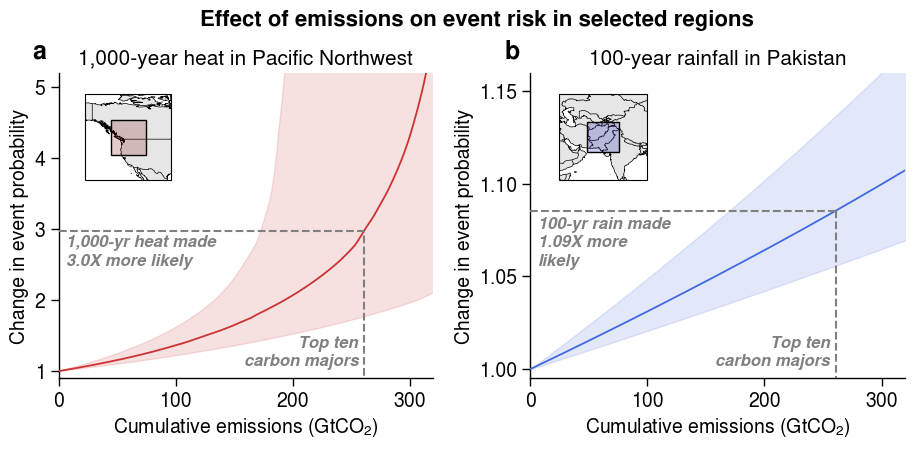

In [65]:
fig = plt.figure(figsize=(9.3,4.3))
tfs = 15

gs0 = gridspec.GridSpec(1,2)
gs0.update(left=0.07,right=0.98,top=0.85,bottom=0.14,wspace=0.26,hspace=0.13)

map_lefts = [0.04,0.55]
plt.figtext(0.52,0.96,"Effect of emissions on event risk in selected regions",
            weight='bold',fontsize=tfs+1,ha="center")

lbs = ["a","b"]
    
for j in [0,1]:
    ax = plt.subplot(gs0[0,j])

    if j == 0:
        plt.title("1,000-year heat in Pacific Northwest",fontsize=tfs)
        exceed = event_exceedance_prob_pnw
        prob_changes = event_prob_changes_pnw.where(event_prob_changes_pnw<10000,10000)
        plt.ylabel(r"Change in event probability")
        pos = [(350,1),(350,3),(350,4),(350,6)]
        col = [0.8,0.2,0.2]
    else:
        plt.title("100-year rainfall in Pakistan",fontsize=tfs)
        exceed = event_exceedance_prob_pak
        prob_changes = event_prob_changes_pak.where(event_prob_changes_pak<10000,10000)
        plt.ylabel("Change in event probability")
        pos = [(350,1.03),(350,1.08),(350,1.1),(350,1.15)]
        col = "royalblue"

    plt.xlabel(r"Cumulative emissions (GtCO$_2$)")
    
    ## plot
    prob_changes_plot = prob_changes.weighted(params_txx.modelwgt).quantile(q=[0.05,0.5,0.95],dim="model")
    ax.fill_between(prob_changes_plot.emission,prob_changes_plot.sel(quantile=0.05),
                    prob_changes_plot.sel(quantile=0.95),color=col,alpha=0.15,zorder=2)
    plt.plot(prob_changes_plot.emission,prob_changes_plot.sel(quantile=0.5),color=col,
             linewidth=1.3,zorder=3)
    


    ## Other stuff
    
    ch = exceed.event_change.values
    plt.xlim([0,320])
    if j == 0:
        plt.ylim([0.9,5.2])
    else:
        plt.ylim([0.995,1.16])
        plt.yticks([1,1.05,1.1,1.15])

    tcol = "gray"
    
    
    cms_str = "Top ten"+"\n"+"carbon majors"
    plt.text(0.8,0.04,cms_str,fontsize=12,style='italic',
             fontweight="bold",color=tcol,transform=ax.transAxes,ha="right",zorder=5)
    #plt.axvline(x=cms_sum,color=tcol,linewidth=1.5,linestyle="--")
    
    
    if j==0:
        print("carbon majors")
        print(cms_sum)
        p_change1 = event_prob_changes_pnw.where(event_prob_changes_pnw<10000,10000).sel(emission=cms_sum,method="nearest")
        #p_change = event_prob_changes_pnw.sel(emission=cms_sum,method="nearest").weighted(params_txx.modelwgt).quantile(q=0.5)
        #p_change = event_prob_changes_pnw.sel(emission=cms_sum,method="nearest").median(dim="model")
        p_change = p_change1.weighted(params_txx.modelwgt).quantile(q=0.5)
        print("pnw doubling probability")
        print((event_prob_changes_pnw.sel(emission=cms_sum,method="nearest") > 2).weighted(params_txx.modelwgt).mean(dim="model").values)
        plt.text(0.02,0.37,"1,000-yr heat made"+"\n"+str(np.around(p_change.values,1))+"X more likely",
                 color=tcol,fontweight="bold",transform=ax.transAxes,ha="left",style='italic',fontsize=12)
        print("pnw 10k probability")
        print((event_prob_changes_pnw.sel(emission=cms_sum,method="nearest") >= 10000).weighted(params_txx.modelwgt).mean(dim="model").values)
    else:
        p_change1 = event_prob_changes_pak.where(event_prob_changes_pak<10000,10000).sel(emission=cms_sum,method="nearest")
        #p_change = event_prob_changes_pak.sel(emission=cms_sum,method="nearest").weighted(params_txx.modelwgt).quantile(q=0.5)
        #p_change = event_prob_changes_pak.sel(emission=cms_sum,method="nearest").median(dim="model")
        p_change = p_change1.weighted(params_txx.modelwgt).quantile(q=0.5)
        plt.text(0.02,0.37,"100-yr rain made"+"\n"+str(np.around(p_change.values,2))+"X more"+"\n"+"likely",
                 color=tcol,fontweight="bold",transform=ax.transAxes,ha="left",style='italic',fontsize=12)
    
    plt.plot([0,cms_sum],[p_change,p_change],color=tcol,linewidth=1.5,linestyle="--",zorder=6)
    plt.plot([cms_sum,cms_sum],[0,p_change],color=tcol,linewidth=1.5,linestyle="--",zorder=6)
    
    lbx = -0.07
    lby = 1.05
    plt.text(lbx,lby,lbs[j],fontsize=18,transform=ax.transAxes,fontweight="bold")

    # colorbar
    #cb = plt.colorbar()
    
    ## map
    # 40:48,285:295
    map_ax = fig.add_axes([map_lefts[j],0.6,0.21,0.2],projection=ccrs.PlateCarree())
    margin = 15
    if j==0:
        map_ax.set_extent([pnw_lon1-margin,pnw_lon2+margin,pnw_lat1-margin,pnw_lat2+margin],crs=ccrs.PlateCarree())
        map_col = [0.5,0,0,0.2]
        xy = [pnw_lon1,pnw_lat1]
        wd = pnw_lon2-pnw_lon1
        ht = pnw_lat2-pnw_lat1
    else:
        #map_ax.set_extent([281,298,36,52],crs=ccrs.PlateCarree())
        map_ax.set_extent([pak_lon1-margin,pak_lon2+margin,pak_lat1-margin,pak_lat2+margin],crs=ccrs.PlateCarree())
        map_col = [0,0,0.65,0.2]
        xy = [pak_lon1,pak_lat1]
        wd = pak_lon2-pak_lon1
        ht = pak_lat2-pak_lat1
    for spine in map_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
        spine.set_zorder(6)
    # features
    map_ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.9,0.9,0.9],
                        zorder=4,linewidth=0.5)
    map_ax.add_feature(cart.feature.BORDERS, edgecolor="black",
                        zorder=5,linewidth=0.5)
    #if j == 0:
    #    map_ax.add_feature(cart.feature.STATES, edgecolor="black",facecolor=[0.9,0.9,0.9],
     #                   zorder=6,linewidth=0.5)
    
    map_ax.add_patch(mpatches.Rectangle(xy=xy, width=wd,height=ht,
                                    facecolor=map_col, edgecolor='k',
                                    transform=ccrs.PlateCarree(),zorder=10))


plt.savefig(loc_figs+"Fig4_Oct2025_v4.pdf")
plt.show()